<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

"Downloading GEFCom14-S..."


Das System kann den angegebenen Pfad nicht finden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.


"------------------------------"
"Downloaded GEFCom14-S in data/"


# Select Task

In [2]:
task = 15

# Prepare data

In [3]:
import numpy as np
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task + 1}/train{task + 1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [6]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SURFACE SOLAR RADIATION {zoneid}', f'SURFACE THERMAL RADIATION {zoneid}', f'TOP NET SOLAR RADIATION {zoneid}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [7]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
yq_output_zones = []

for x_input, y_output in zip(x_input_zones, y_output_zones):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

# Train the linear regression model (ANN6)

In [10]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index().drop('TIMESTAMP', axis=1).rename(columns={
        f'SURFACE SOLAR RADIATION {zoneid}': 0,
        f'SURFACE THERMAL RADIATION {zoneid}': 1,
        f'TOP NET SOLAR RADIATION {zoneid}': 2})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,0,1,2
0,0.075036,0.034681,0.076927
1,0.155907,0.070565,0.159924
2,0.230590,0.106171,0.240292
3,0.287023,0.141938,0.304604
4,0.324356,0.180378,0.352287
...,...,...,...
19699,0.241159,0.557521,0.254016
19700,0.241159,0.584266,0.254016
19701,0.243504,0.610605,0.257703
19702,0.260143,0.638128,0.277010


## Prepare data for regression model

In [11]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x.columns = range(24 * 3)
    x_zones.append(x)

x_zones[0]

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
23,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,...,0.304604,0.230590,0.106171,0.240292,0.155907,0.070565,0.159924,0.075036,0.034681,0.076927
24,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,...,0.352287,0.287023,0.141938,0.304604,0.230590,0.106171,0.240292,0.155907,0.070565,0.159924
25,0.096816,0.076731,0.116198,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,...,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604,0.230590,0.106171,0.240292
26,0.149261,0.116550,0.177444,0.096816,0.076731,0.116198,0.050003,0.037880,0.058629,0.450155,...,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604
27,0.201841,0.155451,0.237863,0.149261,0.116550,0.177444,0.096816,0.076731,0.116198,0.050003,...,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,0.241159,0.557521,0.254016,0.241159,0.530769,0.254016,0.241159,0.502934,0.254016,0.241159,...,0.179764,0.075720,0.749951,0.149421,0.064285,0.720290,0.134269,0.062996,0.688923,0.131471
19700,0.241159,0.584266,0.254016,0.241159,0.557521,0.254016,0.241159,0.530769,0.254016,0.241159,...,0.043290,0.103106,0.778108,0.179764,0.075720,0.749951,0.149421,0.064285,0.720290,0.134269
19701,0.243504,0.610605,0.257703,0.241159,0.584266,0.254016,0.241159,0.557521,0.254016,0.241159,...,0.094505,0.042290,0.026390,0.043290,0.103106,0.778108,0.179764,0.075720,0.749951,0.149421
19702,0.260143,0.638128,0.277010,0.243504,0.610605,0.257703,0.241159,0.584266,0.254016,0.241159,...,0.145261,0.093253,0.052707,0.094505,0.042290,0.026390,0.043290,0.103106,0.778108,0.179764


## Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=10).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, support]
    x_new_zones.append(x_new)

(18984, 72)
(18984,)
[10 13 16 19 22 58 61 64 67 70]
(18984, 72)
(18984,)
[13 16 19 22 25 58 61 64 67 70]
(18984, 72)
(18984,)
[10 13 16 19 22 58 61 64 67 70]


In [13]:
#x_normalized = (x_new - x_new.mean()) / x_new.std()
#x_normalized

# Training

In [14]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 2

predictions_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    predictions = [pd.DataFrame() for _ in range(ensemble_size)]

    for p in tqdm(range(1, 100)):
        for prediction in predictions:
            y = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
            model = MLPRegressor(hidden_layer_sizes=(6,))

            trained = model.fit(x_new[:-gefcom14_metadata['prediction_length']], y)
            prediction.insert(p-1, str(p/100), trained.predict(x_new[-gefcom14_metadata['prediction_length']:]))
    predictions_zones.append(predictions)

100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


In [15]:
predictions_zones[0][0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.163404,0.188751,0.239559,0.238502,0.270057,0.316178,0.322413,0.330235,0.337582,0.316956,...,0.798513,0.792358,0.795162,0.819905,0.844657,0.790281,0.720388,0.820961,0.854651,0.807800
1,0.163404,0.188338,0.241051,0.247235,0.286564,0.348452,0.329444,0.338608,0.341610,0.319393,...,0.828118,0.789249,0.816484,0.843131,0.846176,0.833000,0.720388,0.815120,0.886827,0.804515
2,0.163404,0.187634,0.244340,0.255976,0.303653,0.354361,0.337294,0.348800,0.346182,0.322758,...,0.857844,0.787118,0.837381,0.866089,0.847722,0.873894,0.720388,0.808117,0.918491,0.806456
3,0.163404,0.168114,0.215366,0.199907,0.276631,0.205797,0.210135,0.266916,0.288636,0.283704,...,0.709143,0.710938,0.716676,0.701655,0.737903,0.728878,0.720388,0.713023,0.773464,0.684069
4,0.074407,0.075042,0.087360,0.078771,0.054330,0.099380,0.160262,0.149702,0.125962,0.150055,...,0.580673,0.552075,0.535170,0.606357,0.617078,0.621446,0.720388,0.642163,0.638398,0.583185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.007996,-0.069912,0.012124,-0.036735,-0.039966,-0.015800,-0.018508,-0.040896,0.004928,-0.054188,...,0.278083,0.277672,0.327531,0.324783,0.357929,0.354280,0.325435,0.262071,0.384734,0.324395
716,-0.027171,-0.119002,-0.009117,-0.035724,-0.074841,-0.034581,-0.026040,-0.018335,-0.037899,-0.044368,...,0.348485,0.419787,0.376895,0.417683,0.425865,0.441203,0.464435,0.506333,0.494236,0.423776
717,-0.009971,-0.048298,-0.012439,-0.019575,-0.042886,-0.023115,0.024265,-0.001705,-0.018025,-0.022087,...,0.404870,0.496660,0.462393,0.478774,0.497426,0.485792,0.537291,0.640710,0.598127,0.623570
718,0.003340,0.071590,0.005830,-0.001056,0.046416,-0.003977,0.018851,0.032934,0.012308,0.077960,...,0.501001,0.566846,0.549562,0.561348,0.558768,0.577084,0.612260,0.683301,0.601030,0.699444


In [16]:
averaged_predictions_zones = []

for i, predictions in enumerate(predictions_zones):
    zoneid = i+1
    # ensemble averaging
    averaged_predictions = pd.DataFrame()

    for p in range(1, 100):
        quantile_columns = [prediction[str(p/100)] for prediction in predictions]
        averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))

    averaged_predictions.insert(0, 'ZONEID', zoneid)
    averaged_predictions.insert(0, 'TIMESTAMP', predictions[0].index)
    averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

    averaged_predictions_zones.append(averaged_predictions)

In [17]:
predictions_avg = pd.concat(averaged_predictions_zones)

# Postprocessing: Remove quantile crossing

In [18]:
# sorting

# prediction = np.maximum(prediction, 0)
# prediction.values.sort()
# prediction

In [19]:
# maximum

prediction = predictions_avg
prediction['0.01'] = np.maximum(prediction['0.01'], 0)
for p in range(2, 100):
    prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
0,1,0.165144,0.187938,0.220716,0.246568,0.257210,0.306213,0.306213,0.323966,0.339670,...,0.779335,0.780765,0.795368,0.819587,0.827435,0.827435,0.827435,0.838712,0.838712,0.848934
1,1,0.165379,0.204030,0.220893,0.243014,0.299527,0.322767,0.322767,0.332469,0.343641,...,0.791858,0.791858,0.821658,0.846098,0.846098,0.846098,0.846098,0.864149,0.864149,0.875525
2,1,0.165851,0.219651,0.222490,0.239435,0.328095,0.328095,0.329610,0.342649,0.348092,...,0.815463,0.815463,0.847344,0.872468,0.872468,0.872468,0.872468,0.889387,0.889387,0.904399
3,1,0.150854,0.178407,0.192101,0.201317,0.250775,0.250775,0.250775,0.250775,0.271954,...,0.687585,0.687585,0.696098,0.696098,0.723581,0.725518,0.725518,0.725518,0.725518,0.725518
4,1,0.077538,0.077538,0.078582,0.097286,0.097286,0.115357,0.133180,0.141754,0.141754,...,0.559286,0.559286,0.559286,0.591690,0.612256,0.618431,0.659756,0.659756,0.659756,0.665116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.330174,0.362085,0.362085,0.362085,0.362085,0.418588,0.418588,0.427265,0.437833,0.498918
716,3,0.000000,0.021732,0.021732,0.021732,0.021732,0.021732,0.021732,0.021732,0.021732,...,0.405298,0.416001,0.416001,0.443032,0.461721,0.552730,0.552730,0.552730,0.621186,0.621186
717,3,0.003784,0.003784,0.003784,0.020093,0.020093,0.020093,0.020093,0.020093,0.020093,...,0.498411,0.509352,0.521497,0.531997,0.548994,0.590661,0.590661,0.612179,0.650273,0.650273


# Plotting the quantile prediction for the first entries

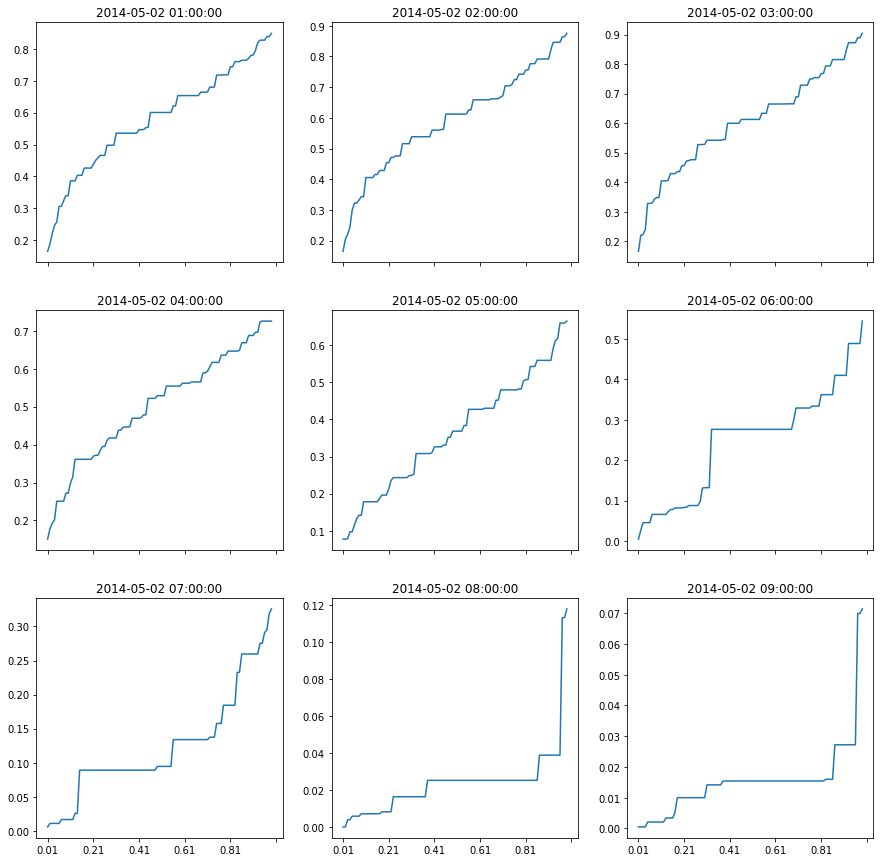

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [21]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [22]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 15 with NNQF: 0.04539
